<a href="https://colab.research.google.com/github/LEEINSEO-0118/optiver/blob/main/TOAD/Optiver_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import random

import torch
import torch.nn as nn
import torch.optim as optim

In [64]:
seed = 2023
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [65]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

# 데이터 로드

In [66]:
                                                                                # 주 폴더
file_path = '/content/drive/MyDrive/ai부트캠프/Deep_Learning/DL_PJT/DATA/optiver-trading-at-the-close/'

train = pd.read_csv(file_path + 'train.csv')
test = pd.read_csv(file_path + 'example_test_files/test.csv')
re_targets = pd.read_csv(file_path + 'example_test_files/revealed_targets.csv')
submission = pd.read_csv(file_path + 'example_test_files/sample_submission.csv')

print(train.shape, test.shape, re_targets.shape, submission.shape)

(5237980, 17) (33000, 16) (33162, 7) (33000, 3)


# EDA

## train

In [67]:
train.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


In [68]:
train.info() # row_id 제거 예정

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   date_id                  int64  
 2   seconds_in_bucket        int64  
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int64  
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
 15  time_id                  int64  
 16  row_id                   object 
dtypes: float64(11), int64(5), object(1)
memory usage: 679.4+ MB


In [69]:
train.isnull().sum() # far/near price null 값 0으로 대체 예정, 나머지 null 행 삭제

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2894342
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
dtype: int64

In [70]:
train.target.describe()

count    5.237892e+06
mean    -4.756125e-02
std      9.452860e+00
min     -3.852898e+02
25%     -4.559755e+00
50%     -6.020069e-02
75%      4.409552e+00
max      4.460704e+02
Name: target, dtype: float64

In [71]:
# sns.lineplot(data = train, x = train.index, y = train.target)

In [72]:
for col in train.columns:
    print(f'{col} unique values : {len(train[col].unique())}')

stock_id unique values : 200
date_id unique values : 481
seconds_in_bucket unique values : 55
imbalance_size unique values : 2971864
imbalance_buy_sell_flag unique values : 3
reference_price unique values : 28742
matched_size unique values : 2948863
far_price unique values : 95740
near_price unique values : 84626
bid_price unique values : 28314
bid_size unique values : 2591773
ask_price unique values : 28267
ask_size unique values : 2623254
wap unique values : 31507
target unique values : 15935
time_id unique values : 26455
row_id unique values : 5237980


## revealed targets

In [73]:
re_targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33162 entries, 0 to 33161
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   stock_id           33000 non-null  float64
 1   date_id            33162 non-null  int64  
 2   seconds_in_bucket  33162 non-null  int64  
 3   time_id            33162 non-null  int64  
 4   revealed_target    33000 non-null  float64
 5   revealed_date_id   33000 non-null  float64
 6   revealed_time_id   33000 non-null  float64
dtypes: float64(4), int64(3)
memory usage: 1.8 MB


In [74]:
re_targets.isnull().sum()

stock_id             162
date_id                0
seconds_in_bucket      0
time_id                0
revealed_target      162
revealed_date_id     162
revealed_time_id     162
dtype: int64

revealed target은 test데이터와 매치됨

revealed target의 revealed 데이터들은 동일 주식의 하루 전날의 데이터들.

train 데이터에 revealed target을 만들어서 붙여서 학습해보자.

In [75]:
train[(train.stock_id == 0) & (train.date_id == 477)].head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
5193980,0,477,0,7485534.85,-1,1.000308,9375793.14,NaN,NaN,0.999958,9715.50,1.000133,30866.40,1.000000,-2.310276,26235,477_0_0
5194180,0,477,10,6980193.38,-1,1.000133,9881134.61,NaN,NaN,1.000133,12632.36,1.000308,40476.36,1.000175,-7.200241,26236,477_10_0
5194380,0,477,20,6980193.38,-1,1.000133,9881134.61,NaN,NaN,1.000133,44870.60,1.000308,47565.44,1.000218,-7.500052,26237,477_20_0
5194580,0,477,30,6980193.38,-1,1.000133,9881134.61,NaN,NaN,1.000133,15147.40,1.000308,36931.82,1.000184,-12.480021,26238,477_30_0
5194780,0,477,40,6980193.38,-1,1.000133,9881134.61,NaN,NaN,1.000133,28580.00,1.000308,36988.99,1.000209,-9.570122,26239,477_40_0


In [76]:
re_targets[re_targets.stock_id == 0]

,stock_id,date_id,seconds_in_bucket,time_id,revealed_target,revealed_date_id,revealed_time_id
0,0.0,478,0,26290,-2.310276,477.0,26235.0
200,0.0,478,10,26290,-7.200241,477.0,26236.0
400,0.0,478,20,26290,-7.500052,477.0,26237.0
600,0.0,478,30,26290,-12.480021,477.0,26238.0
800,0.0,478,40,26290,-9.570122,477.0,26239.0
...,...,...,...,...,...,...,...
32108,0.0,480,500,26400,1.579523,479.0,26395.0
32308,0.0,480,510,26400,-0.180006,479.0,26396.0
32508,0.0,480,520,26400,2.199411,479.0,26397.0
32708,0.0,480,530,26400,1.929998,479.0,26398.0


## test

In [77]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 0 to 32999
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   stock_id                 33000 non-null  int64  
 1   date_id                  33000 non-null  int64  
 2   seconds_in_bucket        33000 non-null  int64  
 3   imbalance_size           33000 non-null  float64
 4   imbalance_buy_sell_flag  33000 non-null  int64  
 5   reference_price          33000 non-null  float64
 6   matched_size             33000 non-null  float64
 7   far_price                14771 non-null  float64
 8   near_price               15000 non-null  float64
 9   bid_price                33000 non-null  float64
 10  bid_size                 33000 non-null  float64
 11  ask_price                33000 non-null  float64
 12  ask_size                 33000 non-null  float64
 13  wap                      33000 non-null  float64
 14  time_id               

In [78]:
test.isnull().sum() # far/near price는 0으로 대체

stock_id                       0
date_id                        0
seconds_in_bucket              0
imbalance_size                 0
imbalance_buy_sell_flag        0
reference_price                0
matched_size                   0
far_price                  18229
near_price                 18000
bid_price                      0
bid_size                       0
ask_price                      0
ask_size                       0
wap                            0
time_id                        0
row_id                         0
dtype: int64

In [79]:
test.date_id.describe() # 478-480 까지의 date_id가 존재함. triain 에서 위 행들을 제거하고 학습해보자.

count    33000.000000
mean       479.000000
std          0.816509
min        478.000000
25%        478.000000
50%        479.000000
75%        480.000000
max        480.000000
Name: date_id, dtype: float64

In [80]:
test_stock_0 = test[test.stock_id==0]
train[(train.stock_id == 0) & (train.date_id >= 478)].drop(columns = 'target')

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,time_id,row_id
5204980,0,478,0,3753451.43,-1,0.999875,11548975.43,NaN,NaN,0.999875,22940.00,1.000050,9177.60,1.000000,26290,478_0_0
5205180,0,478,10,3771174.79,-1,1.000050,11550982.93,NaN,NaN,1.000050,17208.00,1.000224,21456.38,1.000127,26291,478_10_0
5205380,0,478,20,3771174.79,-1,1.000050,11550982.93,NaN,NaN,1.000050,917.76,1.000224,41535.88,1.000054,26292,478_20_0
5205580,0,478,30,4080903.36,-1,1.000224,11539511.50,NaN,NaN,1.000224,30176.62,1.000399,15033.56,1.000341,26293,478_30_0
5205780,0,478,40,4045858.14,-1,1.000224,11574556.71,NaN,NaN,1.000224,20136.87,1.000399,25706.24,1.000301,26294,478_40_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5236980,0,480,500,0.00,0,0.999017,42161928.97,0.999017,0.999017,0.999017,53827.20,0.999193,146071.08,0.999065,26450,480_500_0
5237180,0,480,510,0.00,0,0.998842,42161928.97,0.998842,0.998842,0.998842,157865.40,0.999017,120926.08,0.998941,26451,480_510_0
5237380,0,480,520,475513.69,-1,0.999193,41686415.27,0.999017,0.999017,0.999193,57596.67,0.999368,46780.58,0.999289,26452,480_520_0
5237580,0,480,530,475513.69,-1,0.999193,41686415.27,0.999017,0.999017,0.999193,156610.53,0.999368,122677.94,0.999291,26453,480_530_0


In [81]:
submission

,time_id,row_id,target
0,26290,478_0_0,1
1,26290,478_0_1,1
2,26290,478_0_2,1
3,26290,478_0_3,1
4,26290,478_0_4,1
...,...,...,...
32995,26454,480_540_195,1
32996,26454,480_540_196,1
32997,26454,480_540_197,1
32998,26454,480_540_198,1


# Data Processing

## Train data에서 time_id, Object 컬럼 삭제

In [82]:
train_df = train.drop(columns = 'time_id')
train_df = train_df.drop(columns = 'row_id')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 15 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   date_id                  int64  
 2   seconds_in_bucket        int64  
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int64  
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
dtypes: float64(11), int64(4)
memory usage: 599.4 MB


## Null 값 처리

In [83]:
# far/near price 0과 1대체
# train_df = train.copy()
train_df.near_price = train_df.near_price.fillna(0)
train_df.far_price = train_df.far_price.fillna(1)
train_df.isnull().sum()

stock_id                     0
date_id                      0
seconds_in_bucket            0
imbalance_size             220
imbalance_buy_sell_flag      0
reference_price            220
matched_size               220
far_price                    0
near_price                   0
bid_price                  220
bid_size                     0
ask_price                  220
ask_size                     0
wap                        220
target                      88
dtype: int64

In [84]:
# 220, 88개의 Null 값 drop
# train_df = train_df.dropna()
# train_df.isnull().sum()

## NULL 값 처리 KNN Imputer

In [85]:
# nan 값이 있는 주식 리스트
nan_stock = train_df[train_df.isnull().any(axis = 1)].stock_id.unique()
nan_stock

array([131, 101, 158,  19])

In [86]:
# KNN Imputer
from sklearn.impute import KNNImputer
col_list = ['imbalance_size', 'reference_price', 'matched_size', 'bid_price', 'ask_price', 'wap', 'target']
for stock in nan_stock:
    imputer = KNNImputer(n_neighbors=3)
    # 주식 별로 데이터 추출
    df = train_df[train_df.stock_id == stock]
    idx = df.index
    # 주식 별 nan 값 채우기
    df = pd.DataFrame(imputer.fit_transform(df), columns = train_df.columns)
    for col in col_list:
        train_df.loc[idx, col] = df[col].values

In [87]:
train_df.isnull().sum()

stock_id                   0
date_id                    0
seconds_in_bucket          0
imbalance_size             0
imbalance_buy_sell_flag    0
reference_price            0
matched_size               0
far_price                  0
near_price                 0
bid_price                  0
bid_size                   0
ask_price                  0
ask_size                   0
wap                        0
target                     0
dtype: int64

## Train data에 revealed target 값 추가

revealed_target 데이터 처럼 각 행에 ***하루 전의 동 주식, 동 second_in_bucket*** 조건의 target을 저장

In [88]:
re_targets[re_targets.stock_id == 0].head()

,stock_id,date_id,seconds_in_bucket,time_id,revealed_target,revealed_date_id,revealed_time_id
0,0.0,478,0,26290,-2.310276,477.0,26235.0
200,0.0,478,10,26290,-7.200241,477.0,26236.0
400,0.0,478,20,26290,-7.500052,477.0,26237.0
600,0.0,478,30,26290,-12.480021,477.0,26238.0
800,0.0,478,40,26290,-9.570122,477.0,26239.0


In [89]:
for n in list(train_df.groupby(['stock_id', 'date_id']).target.count()):
    if n != 55:
        print('hello')

In [90]:
train_df['revealed_target'] = train_df.groupby(['stock_id'])['target'].shift(55)

In [91]:
train_df[(train_df.stock_id == 0) & (train_df.date_id == 478)].head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,revealed_target
5204980,0,478,0,3753451.43,-1,0.999875,11548975.43,1.0,0.0,0.999875,22940.00,1.000050,9177.60,1.000000,-5.429983,-2.310276
5205180,0,478,10,3771174.79,-1,1.000050,11550982.93,1.0,0.0,1.000050,17208.00,1.000224,21456.38,1.000127,-3.489852,-7.200241
5205380,0,478,20,3771174.79,-1,1.000050,11550982.93,1.0,0.0,1.000050,917.76,1.000224,41535.88,1.000054,-3.330112,-7.500052
5205580,0,478,30,4080903.36,-1,1.000224,11539511.50,1.0,0.0,1.000224,30176.62,1.000399,15033.56,1.000341,-1.900196,-12.480021
5205780,0,478,40,4045858.14,-1,1.000224,11574556.71,1.0,0.0,1.000224,20136.87,1.000399,25706.24,1.000301,2.189875,-9.570122


In [92]:
train_df.isnull().sum()

stock_id                       0
date_id                        0
seconds_in_bucket              0
imbalance_size                 0
imbalance_buy_sell_flag        0
reference_price                0
matched_size                   0
far_price                      0
near_price                     0
bid_price                      0
bid_size                       0
ask_price                      0
ask_size                       0
wap                            0
target                         0
revealed_target            11000
dtype: int64

In [93]:
# 일단 date_id = 0 drop
train_df = train_df.dropna()

## Feature 생성

In [94]:
from itertools import combinations

prices = ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]

# V1
train_df["volume"] = train_df.eval("ask_size + bid_size")
train_df["mid_price"] = train_df.eval("(ask_price + bid_price) / 2")
train_df["liquidity_imbalance"] = train_df.eval("(bid_size-ask_size)/(bid_size+ask_size)")
train_df["matched_imbalance"] = train_df.eval("(imbalance_size-matched_size)/(matched_size+imbalance_size)")
train_df["size_imbalance"] = train_df.eval("bid_size / ask_size")

for c in combinations(prices, 2):
    train_df[f"{c[0]}_{c[1]}_imb"] = train_df.eval(f"({c[0]} - {c[1]})/({c[0]} + {c[1]})")

# for c in [['ask_price', 'bid_price', 'wap', 'reference_price'], sizes]:
#     triplet_feature = calculate_triplet_imbalance_numba(c, train_df)
#     train_df[triplet_feature.columns] = triplet_feature.values

# V2
train_df["imbalance_momentum"] = train_df.groupby(['stock_id'])['imbalance_size'].diff(periods=1).fillna(0) / (train_df['matched_size']+1e-8)
train_df["price_spread"] = train_df["ask_price"] - train_df["bid_price"]
train_df["spread_intensity"] = train_df.groupby(['stock_id'])['price_spread'].diff().fillna(0)
train_df['price_pressure'] = train_df['imbalance_size'] * (train_df['ask_price'] - train_df['bid_price'])
train_df['market_urgency'] = train_df['price_spread'] * train_df['liquidity_imbalance']
train_df['depth_pressure'] = (train_df['ask_size'] - train_df['bid_size']) * (train_df['far_price'] - train_df['near_price'])
train_df['spread_depth_ratio'] = (train_df['ask_price'] - train_df['bid_price']) / (train_df['bid_size'] + train_df['ask_size'])
train_df['mid_price_movement'] = train_df['mid_price'].diff(periods=5).apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
train_df['micro_price'] = ((train_df['bid_price'] * train_df['ask_size']) + (train_df['ask_price'] * train_df['bid_size'])) / (train_df['bid_size'] + train_df['ask_size'])
train_df['relative_spread'] = (train_df['ask_price'] - train_df['bid_price']) / train_df['wap']

# for func in ["mean", "std", "skew", "kurt"]:
#     train_df[f"all_prices_{func}"] = train_df[prices].agg(func, axis=1)
#     train_df[f"all_sizes_{func}"] = train_df[sizes].agg(func, axis=1)

# V3
for col in ['matched_size', 'imbalance_size', 'reference_price', 'imbalance_buy_sell_flag']:
    fill_value = train_df[col].mean()
    for window in [1, 2, 3]:
        train_df[f"{col}_shift_{window}"] = train_df.groupby('stock_id')[col].shift(window).fillna(fill_value)

for col in ['ask_price', 'bid_price', 'ask_size', 'bid_size']:
    for window in [1, 2, 3]:
        train_df[f"{col}_diff_{window}"] = train_df.groupby("stock_id")[col].diff(window).fillna(0)

<ipython-input-94-e245f6554118>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["volume"] = train_df.eval("ask_size + bid_size")
<ipython-input-94-e245f6554118>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["mid_price"] = train_df.eval("(ask_price + bid_price) / 2")
<ipython-input-94-e245f6554118>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [95]:
train_df.columns

Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'target', 'revealed_target', 'volume', 'mid_price',
       'liquidity_imbalance', 'matched_imbalance', 'size_imbalance',
       'reference_price_far_price_imb', 'reference_price_near_price_imb',
       'reference_price_ask_price_imb', 'reference_price_bid_price_imb',
       'reference_price_wap_imb', 'far_price_near_price_imb',
       'far_price_ask_price_imb', 'far_price_bid_price_imb',
       'far_price_wap_imb', 'near_price_ask_price_imb',
       'near_price_bid_price_imb', 'near_price_wap_imb',
       'ask_price_bid_price_imb', 'ask_price_wap_imb', 'bid_price_wap_imb',
       'imbalance_momentum', 'price_spread', 'spread_intensity',
       'price_pressure', 'market_urgency', 'depth_pressure',
       'spread_depth_ratio', 'mid_price_movement', 'micro_

In [96]:
# null 값 가진 columns
na_list = train_df.columns[train_df.isnull().sum() > 0]
na_list

Index(['liquidity_imbalance', 'size_imbalance', 'market_urgency',
       'micro_price'],
      dtype='object')

In [97]:
for col in na_list:
    train_df[col] = train_df[col].fillna(train_df[col].mean())

In [98]:
train_df.isnull().sum()

stock_id                   0
date_id                    0
seconds_in_bucket          0
imbalance_size             0
imbalance_buy_sell_flag    0
                          ..
ask_size_diff_2            0
ask_size_diff_3            0
bid_size_diff_1            0
bid_size_diff_2            0
bid_size_diff_3            0
Length: 70, dtype: int64

In [110]:
a = ['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'currently_scored', 'revealed_target', 'volume',
       'mid_price', 'liquidity_imbalance', 'matched_imbalance',
       'size_imbalance', 'reference_price_far_price_imb',
       'reference_price_near_price_imb', 'reference_price_ask_price_imb',
       'reference_price_bid_price_imb', 'reference_price_wap_imb',
       'far_price_near_price_imb', 'far_price_ask_price_imb',
       'far_price_bid_price_imb', 'far_price_wap_imb',
       'near_price_ask_price_imb', 'near_price_bid_price_imb',
       'near_price_wap_imb', 'ask_price_bid_price_imb', 'ask_price_wap_imb',
       'bid_price_wap_imb', 'imbalance_momentum', 'price_spread',
       'spread_intensity', 'price_pressure', 'market_urgency',
       'depth_pressure', 'spread_depth_ratio', 'mid_price_movement',
       'micro_price', 'relative_spread', 'matched_size_shift_1',
       'matched_size_shift_2', 'matched_size_shift_3',
       'imbalance_size_shift_1', 'imbalance_size_shift_2',
       'imbalance_size_shift_3', 'reference_price_shift_1',
       'reference_price_shift_2', 'reference_price_shift_3',
       'imbalance_buy_sell_flag_shift_1', 'imbalance_buy_sell_flag_shift_2',
       'imbalance_buy_sell_flag_shift_3', 'ask_price_diff_1',
       'ask_price_diff_2', 'ask_price_diff_3', 'bid_price_diff_1',
       'bid_price_diff_2', 'bid_price_diff_3', 'ask_size_diff_1',
       'ask_size_diff_2', 'ask_size_diff_3', 'bid_size_diff_1',
       'bid_size_diff_2', 'bid_size_diff_3']
set(a) - set(train_df.drop(columns = 'target').columns)

{'currently_scored'}

In [111]:
if 'currently_scored' in a:
    print('hele')

hele


In [38]:
# 무한대 값 처리
train_df = train_df[np.isfinite(train_df).all(1)]

In [39]:
train_df.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,ask_price_diff_3,bid_price_diff_1,bid_price_diff_2,bid_price_diff_3,ask_size_diff_1,ask_size_diff_2,ask_size_diff_3,bid_size_diff_1,bid_size_diff_2,bid_size_diff_3
10505,0,1,0,1870169.40,1,0.999923,5132566.71,1.0,0.0,0.999601,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10506,1,1,0,648832.14,-1,0.999710,2714505.33,1.0,0.0,0.999884,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10507,2,1,0,867091.90,1,1.000126,4229483.69,1.0,0.0,0.999645,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10508,3,1,0,24475003.80,1,0.999356,9177225.49,1.0,0.0,0.999571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10509,4,1,0,216002.20,-1,0.999875,11183560.41,1.0,0.0,0.999875,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Data Scaling

In [40]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import joblib

# scaler = MinMaxScaler()
scaler = StandardScaler()
X_ = scaler.fit_transform(train_df.drop(columns = 'target').values)
y_ = train_df.target.values

# save scaler
joblib.dump(scaler, 'scaler.save')

['scaler.save']

In [41]:
X_

array([[-1.71563237e+00, -1.74335259e+00, -1.70084551e+00, ...,
        -3.96056140e-05, -6.95945978e-05, -9.50543502e-05],
       [-1.69835290e+00, -1.74335259e+00, -1.70084551e+00, ...,
        -3.96056140e-05, -6.95945978e-05, -9.50543502e-05],
       [-1.68107343e+00, -1.74335259e+00, -1.70084551e+00, ...,
        -3.96056140e-05, -6.95945978e-05, -9.50543502e-05],
       ...,
       [ 1.68842318e+00,  1.72153950e+00,  1.70083517e+00, ...,
        -7.84502190e-01, -3.63838834e-02,  1.34754441e-01],
       [ 1.70570265e+00,  1.72153950e+00,  1.70083517e+00, ...,
        -1.74243181e-01, -3.96234109e+00, -3.84675801e+00],
       [ 1.72298212e+00,  1.72153950e+00,  1.70083517e+00, ...,
        -3.37051878e-01,  2.21901354e-01, -3.58789695e+00]])

# Modeling

## Data split

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size = 0.2, random_state = 2023)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(4181514, 69) (4181514,) (1045379, 69) (1045379,)


## Data Prepartaion

In [43]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [44]:
X_train

array([[ 9.79964919e-01, -1.08509543e+00,  1.25983003e-01, ...,
        -1.48729880e-01, -4.41576918e-02, -5.47318741e-01],
       [ 5.82537113e-01,  1.48283085e+00, -1.13389873e+00, ...,
        -2.54541764e-01,  2.75690763e-02, -2.25370762e-01],
       [-1.59467608e+00, -1.11402981e+00,  1.00790022e+00, ...,
         6.65274248e-03,  3.15695261e-02,  2.35965230e-02],
       ...,
       [ 1.03180333e+00,  6.94368980e-01,  1.00790022e+00, ...,
         7.39477409e-02, -1.84923579e-01,  3.35615432e-01],
       [ 5.99816583e-01, -1.27316891e+00, -2.51981517e-01, ...,
         1.14875615e-03,  3.02980793e-01,  4.06003413e-01],
       [ 1.50550368e-01,  7.16069766e-01, -1.25993344e-01, ...,
        -1.16597661e-01, -8.48233485e-02, -2.74869455e-03]])

In [45]:
# Tensor 변환

X_tensor = torch.from_numpy(X_train).float()
y_tensor = torch.from_numpy(y_train).float()
Xval_tensor =  torch.from_numpy(X_val).float()
yval_tensor = torch.from_numpy(y_val).float()

In [46]:
print(X_tensor.shape, y_tensor.shape, Xval_tensor.shape, yval_tensor.shape)

torch.Size([4181514, 69]) torch.Size([4181514]) torch.Size([1045379, 69]) torch.Size([1045379])


In [47]:
batch_size = 2048

# unsqueeze(1) : 평탄화 tensor에 1차원 추가
y_tensor = y_tensor.unsqueeze(1) # 2차원
train_ds = TensorDataset(X_tensor, y_tensor)

yval_tensor = yval_tensor.unsqueeze(1)
val_ds = TensorDataset(Xval_tensor, yval_tensor)

# ▶ DataLoader : batch_size 만큼 데이터를 이동시켜주는 기능, iteration을 효율적으로 빠르게 하기 위함
train_loader = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_ds, batch_size = batch_size, shuffle = False)

In [48]:
print(X_tensor.shape, y_tensor.shape, Xval_tensor.shape, yval_tensor.shape)

torch.Size([4181514, 69]) torch.Size([4181514, 1]) torch.Size([1045379, 69]) torch.Size([1045379, 1])


## NN 설계

In [49]:
input_dim = X_tensor.shape[1]

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 1)
        # self.fc7 = nn.Linear(16, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.fc6(x)
        return x

In [50]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Model, Loss Function, Optimizer, epochs

In [51]:
model = MLP().to(device)
loss_func = nn.L1Loss()
optimizer = optim.AdamW(model.parameters(), lr = 0.0001)
epochs = 100
model

MLP(
  (fc1): Linear(in_features=69, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=32, bias=True)
  (fc6): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)

Scheduler

In [52]:
# from torch.optim import lr_scheduler

# scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer = optimizer,
#                                                      T_0 = 100,
#                                                      T_mult = 1,
#                                                      eta_min = 0.00001)

## 모델 학습

In [53]:
from tqdm.auto import tqdm

In [54]:
train_epoch_loss = []
valid_epoch_loss = []
for epoch in range(epochs):

    train_iter_loss = []
    bar = tqdm(enumerate(train_loader), total = len(train_loader), desc = 'Train Loop')
    model.train()
    for idx, data in bar:
        inputs, values = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        # print(outputs.shape, values.shape)
        loss = loss_func(outputs, values)
        train_iter_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # if scheduler is not None:
        #     scheduler.step()
        bar.set_postfix(
            Epoch = epoch,
            Current_loss = loss.item(),
            Train_loss = sum(train_iter_loss) / (idx + 1),
            LR = optimizer.param_groups[0]['lr']
        )
    print(f'Epoch [{epoch+1}/{epochs}] - Train loss : {sum(train_iter_loss)/len(train_loader):.4f}')
    train_epoch_loss.append(sum(train_iter_loss) / len(train_loader))

    val_iter_loss = []
    bar = tqdm(enumerate(val_loader), total = len(val_loader), desc = 'Valid Loop')
    model.eval()
    for idx, data in bar:
        with torch.no_grad():
            inputs, values = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = loss_func(outputs, values)
            val_iter_loss.append(loss.item())
            bar.set_postfix(
                Epoch = epoch,
                Current_loss = loss.item(),
                Train_loss = sum(val_iter_loss) / (idx + 1)
            )
    print(f'Epoch [{epoch+1}/{epochs}] - Valid loss : {sum(val_iter_loss)/len(val_loader):.4f}')
    valid_epoch_loss.append(sum(val_iter_loss)/len(val_loader))

Train Loop:   0%|          | 0/2042 [00:00<?, ?it/s]

Epoch [1/100] - Train loss : 6.2956


Valid Loop:   0%|          | 0/511 [00:00<?, ?it/s]

Epoch [1/100] - Valid loss : 6.2956


Train Loop:   0%|          | 0/2042 [00:00<?, ?it/s]

Epoch [2/100] - Train loss : 6.2743


Valid Loop:   0%|          | 0/511 [00:00<?, ?it/s]

Epoch [2/100] - Valid loss : 6.2861


Train Loop:   0%|          | 0/2042 [00:00<?, ?it/s]

Epoch [3/100] - Train loss : 6.2658


Valid Loop:   0%|          | 0/511 [00:00<?, ?it/s]

Epoch [3/100] - Valid loss : 6.2805


Train Loop:   0%|          | 0/2042 [00:00<?, ?it/s]

Epoch [4/100] - Train loss : 6.2591


Valid Loop:   0%|          | 0/511 [00:00<?, ?it/s]

Epoch [4/100] - Valid loss : 6.2757


Train Loop:   0%|          | 0/2042 [00:00<?, ?it/s]

Epoch [5/100] - Train loss : 6.2539


Valid Loop:   0%|          | 0/511 [00:00<?, ?it/s]

Epoch [5/100] - Valid loss : 6.2740


Train Loop:   0%|          | 0/2042 [00:00<?, ?it/s]

Epoch [6/100] - Train loss : 6.2495


Valid Loop:   0%|          | 0/511 [00:00<?, ?it/s]

Epoch [6/100] - Valid loss : 6.2737


Train Loop:   0%|          | 0/2042 [00:00<?, ?it/s]

Epoch [7/100] - Train loss : 6.2459


Valid Loop:   0%|          | 0/511 [00:00<?, ?it/s]

Epoch [7/100] - Valid loss : 6.2666


Train Loop:   0%|          | 0/2042 [00:00<?, ?it/s]

Epoch [8/100] - Train loss : 6.2423


Valid Loop:   0%|          | 0/511 [00:00<?, ?it/s]

Epoch [8/100] - Valid loss : 6.2668


Train Loop:   0%|          | 0/2042 [00:00<?, ?it/s]

Epoch [9/100] - Train loss : 6.2392


Valid Loop:   0%|          | 0/511 [00:00<?, ?it/s]

Epoch [9/100] - Valid loss : 6.2628


Train Loop:   0%|          | 0/2042 [00:00<?, ?it/s]

Epoch [10/100] - Train loss : 6.2362


Valid Loop:   0%|          | 0/511 [00:00<?, ?it/s]

Epoch [10/100] - Valid loss : 6.2616


Train Loop:   0%|          | 0/2042 [00:00<?, ?it/s]

Epoch [11/100] - Train loss : 6.2332


Valid Loop:   0%|          | 0/511 [00:00<?, ?it/s]

Epoch [11/100] - Valid loss : 6.2590


Train Loop:   0%|          | 0/2042 [00:00<?, ?it/s]

Epoch [12/100] - Train loss : 6.2301


Valid Loop:   0%|          | 0/511 [00:00<?, ?it/s]

Epoch [12/100] - Valid loss : 6.2570


Train Loop:   0%|          | 0/2042 [00:00<?, ?it/s]

Epoch [13/100] - Train loss : 6.2274


Valid Loop:   0%|          | 0/511 [00:00<?, ?it/s]

Epoch [13/100] - Valid loss : 6.2570


Train Loop:   0%|          | 0/2042 [00:00<?, ?it/s]

Epoch [14/100] - Train loss : 6.2246


Valid Loop:   0%|          | 0/511 [00:00<?, ?it/s]

Epoch [14/100] - Valid loss : 6.2552


Train Loop:   0%|          | 0/2042 [00:00<?, ?it/s]

Epoch [15/100] - Train loss : 6.2218


Valid Loop:   0%|          | 0/511 [00:00<?, ?it/s]

Epoch [15/100] - Valid loss : 6.2539


Train Loop:   0%|          | 0/2042 [00:00<?, ?it/s]

Epoch [16/100] - Train loss : 6.2193


Valid Loop:   0%|          | 0/511 [00:00<?, ?it/s]

Epoch [16/100] - Valid loss : 6.2568


Train Loop:   0%|          | 0/2042 [00:00<?, ?it/s]

Epoch [17/100] - Train loss : 6.2166


Valid Loop:   0%|          | 0/511 [00:00<?, ?it/s]

Epoch [17/100] - Valid loss : 6.2527


Train Loop:   0%|          | 0/2042 [00:00<?, ?it/s]

Epoch [18/100] - Train loss : 6.2139


Valid Loop:   0%|          | 0/511 [00:00<?, ?it/s]

Epoch [18/100] - Valid loss : 6.2530


Train Loop:   0%|          | 0/2042 [00:00<?, ?it/s]

Epoch [19/100] - Train loss : 6.2113


Valid Loop:   0%|          | 0/511 [00:00<?, ?it/s]

Epoch [19/100] - Valid loss : 6.2544


Train Loop:   0%|          | 0/2042 [00:00<?, ?it/s]

Epoch [20/100] - Train loss : 6.2085


Valid Loop:   0%|          | 0/511 [00:00<?, ?it/s]

Epoch [20/100] - Valid loss : 6.2529


Train Loop:   0%|          | 0/2042 [00:00<?, ?it/s]

Epoch [21/100] - Train loss : 6.2060


Valid Loop:   0%|          | 0/511 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

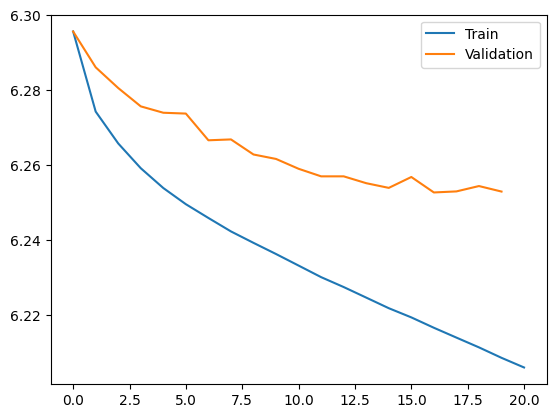

In [55]:
sns.lineplot(data = train_epoch_loss, label = 'Train')
sns.lineplot(data = valid_epoch_loss, label = 'Validation')

plt.show()

In [56]:
train_epoch_loss.index(min(train_epoch_loss))

20

In [57]:
train_min = min(train_epoch_loss)
print(f'Best Train Loss : Epoch [{train_epoch_loss.index(train_min)}/{len(train_epoch_loss)+1}] - Train loss : {train_min}')
valid_min = min(valid_epoch_loss)
print(f'Best Valid Loss : Epoch [{valid_epoch_loss.index(valid_min)}/{len(valid_epoch_loss)+1}] - Valid loss : {valid_min}')

Best Train Loss : Epoch [20/22] - Train loss : 6.205962897748135
Best Valid Loss : Epoch [16/21] - Valid loss : 6.2526799209430495


## Save Model

In [58]:
checkpoint = {'model': MLP(),
              'state_dict': model.state_dict(),
              'optimizer' : optimizer.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

# 예측

In [ ]:
# kaggle

# test_df = test.drop(columns = 'row_id')

In [ ]:
# colab

# test.isnull().sum()
# test_df = test.copy()
# test_df.near_price = test_df.near_price.fillna(0)
# test_df.far_price = test_df.far_price.fillna(0)
# test_df = test_df.drop(columns = 'row_id')
# test_df.info()

In [ ]:
# test_df = scaler.fit_transform(test_df.values)
# test_tensor = torch.from_numpy(test_df).float()
# test_ds = TensorDataset(test_tensor)
# test_loader = DataLoader(test_ds, batch_size = batch_size)

In [ ]:
# test_tensor.shape

In [ ]:
# predictions = []
# bar = tqdm(enumerate(test_loader), total = len(test_loader), desc = 'Test Loop')
# model.eval()
# for idx, data in bar:
#     with torch.no_grad():
#         inputs = data[0].to(device)
#         preds = model(inputs)
#         preds = list(preds.to('cpu').numpy().squeeze())
#         predictions.extend(preds)

In [ ]:
# len(predictions)

In [ ]:
# submission.target = predictions
# submission